In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")
import numpy as np
import matplotlib.pyplot as plt

import src.utils.behavior_map as bm
import src.utils.make_environment as make_env
import src.worlds.mdp2d as mdp2d

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import ParamTuple

from src.utils.visualization import plot_environment

from src.utils.environment_design import EnvironmentDesign

from src.utils.inference.posterior import PosteriorInference



/home/paul/.local/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [2]:
# Set the number of scales and gammas to use
granularity = 15  # 5, 10, 20

# Set up parameters to search over
probs = np.linspace(0.4, 0.95, granularity)
gammas = np.linspace(0.4, 0.95, granularity)

In [3]:
def convert_to_environment(world: mdp2d.Experiment_2D):
    """Converts a world to an environment."""
    N = world.height
    M = world.width

    T = world.mdp.T

    environment = make_env.Environment(
        N=N,
        M=M,
        T_true=T,
        wall_states=[],
        R_sample_mean=None,
        start_state=0,
        n_walls=0,
        R_true=world.rewards,
        goal_states=world.absorbing_states
    )

    return environment

## Define Custom worlds


In [4]:
from src.worlds.mdp2d import Experiment_2D

def make_world(
    height: int,
    width: int,
    rewards: np.array,
    absorbing_states: list,
    wall_states: list
) -> Experiment_2D:

    experiment = Experiment_2D(
        height,
        width,
        rewards = rewards,
        absorbing_states = absorbing_states,
        wall_states=wall_states,
    )

    return experiment

In [5]:
height = 7
width = 7
rewards = np.zeros((height, width))
wall_states = np.zeros((height, width))

rewards[6,0] = 1
rewards[6,6] = 3

# rewards[5,0] = -1
# rewards[4,0] = -1

rewards = rewards.flatten()

goal_states = np.where(rewards > 0)[0]

wall_states[2,0] = 1
# wall_states[4,1] = 1

wall_states = wall_states.flatten()
wall_states = np.where(wall_states > 0)[0]

agent_p = 0.9
agent_gamma = 0.7
p_true=1

true_params = ParamTuple(agent_p, agent_gamma, rewards)

wall_states = [14]

T_true = transition_matrix(height, width, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


custom_world = make_world(height=height,
                          width=width,
                          rewards=rewards,
                          absorbing_states=goal_states,
                          wall_states=wall_states)

big_small = Environment(
    N=height,
    M=width,
    T_true=T_true,
    wall_states=wall_states,
    R_true=rewards,
    start_state=0,
    n_walls=None,
    goal_states=goal_states
)

### Initialize Environment Design class.

In [6]:
env_design = EnvironmentDesign(base_environment=big_small, user_params=true_params)

In [7]:
#Observe human in base environment.
env_design.run_n_episodes(n_episodes=0, bayesian_regret_how="value", candidate_environments_args=None)

Started episode 0.
Finished episode 0.


### Calculate current posterior

Calculate distribution of episode 0, e.g. the prior distribution.
Calculate distribution of episode 1.


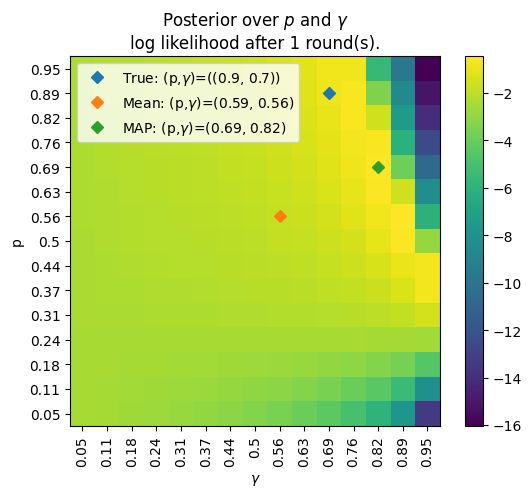

In [8]:
pos_inference = PosteriorInference(expert_trajectories=env_design.all_observations)

pos_inference.calculate_posterior(num_episodes=1)

pos_inference.plot_posterior(episode=1, param_values=true_params, show_true_prob=False)

### Calculate Behavior Map for current environment.

Make both approaches equally comparable from compute perspective 
See where both converge when doing 5-10 iterations of hand engineered
Translate contraction of posterior in some sort of number -> text others
Do a middle of the week check in to discuss whether we want to automate current BM approach or whether we want to scale up to a more complex environment

With the information of the posterior, we "zoom in" on the Behavior Map on the region of the interest. Thereby, we a) reduce compute as we compute the Behavior Map for a smaller region and b) get more detailed information on the impact of the intervention.

Region of interest is $p \in [0.3,1], \gamma \in [0.5,1]$

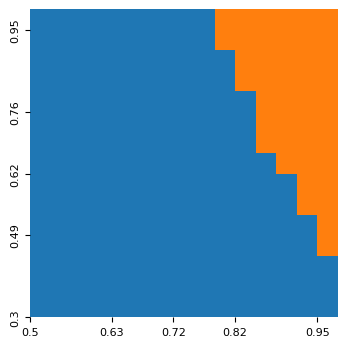

In [9]:
# Set up parameters to search over
probs = np.linspace(0.3, 0.95, granularity)
gammas = np.linspace(0.5, 0.95, granularity)

out = bm.plot_bmap(
    world=custom_world,
    gammas=gammas,
    probs=probs
)

We want to change decision boundary. To this end, we use walls and death states as interventions.

In [10]:
height = 7
width = 7
rewards = np.zeros((height, width))
wall_states = np.zeros((height, width))

rewards[6,0] = 1
rewards[6,6] = 3

rewards[5,1] = -1
rewards[4,1] = -1
rewards[3,1] = -1
rewards[2,1] = -1
# rewards[1,1] = -1

rewards = rewards.flatten()


goal_states = np.where(rewards > 0)[0]

# wall_states[2,0] = 1
# wall_states[2,1] = 1
# wall_states[4,1] = 1

wall_states[2,2] = 1

wall_states = wall_states.flatten()
wall_states = np.where(wall_states > 0)[0]



agent_p = 0.9
agent_gamma = 0.7
p_true=1

true_params = ParamTuple(agent_p, agent_gamma, rewards)

T_true = transition_matrix(height, width, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


learned_world = make_world(height=height,
                          width=width,
                          rewards=rewards,
                          absorbing_states=goal_states,
                          wall_states=wall_states)

big_small_2 = Environment(
    N=height,
    M=width,
    T_true=T_true,
    wall_states=wall_states,
    R_true=rewards,
    start_state=0,
    n_walls=None,
    goal_states=goal_states
)

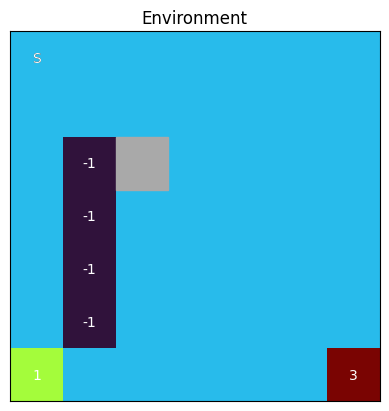

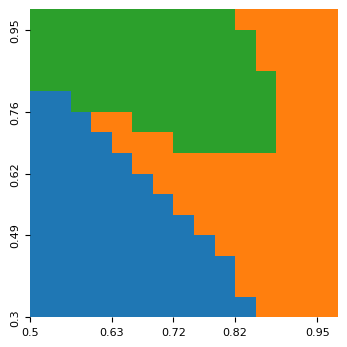

In [11]:
plot_environment(rewards.reshape(height, width), wall_states)

out = bm.plot_bmap(
    world=learned_world,
    gammas=gammas,
    probs=probs
)

In [12]:
env_update = env_design._observe_human(environment=big_small_2, n_trajectories=25)

In [13]:
env_design.all_observations.append(env_update)

In [14]:
pos_inference = PosteriorInference(expert_trajectories=env_design.all_observations)
pos_inference.calculate_posterior(num_episodes=2)

Calculate distribution of episode 0, e.g. the prior distribution.
Calculate distribution of episode 1.
Calculate distribution of episode 2.


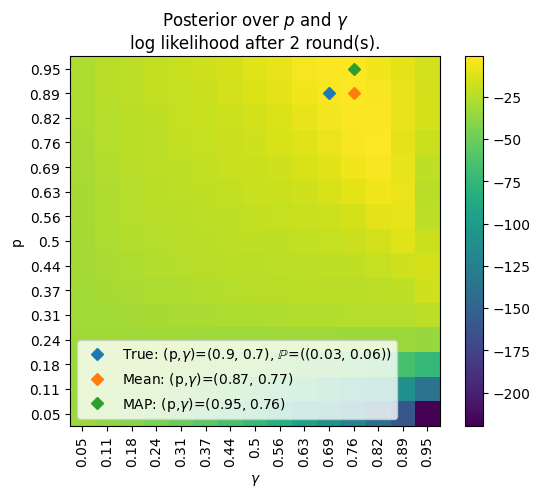

In [15]:
pos_inference.plot_posterior(episode=2, param_values=true_params, show_true_prob=True)

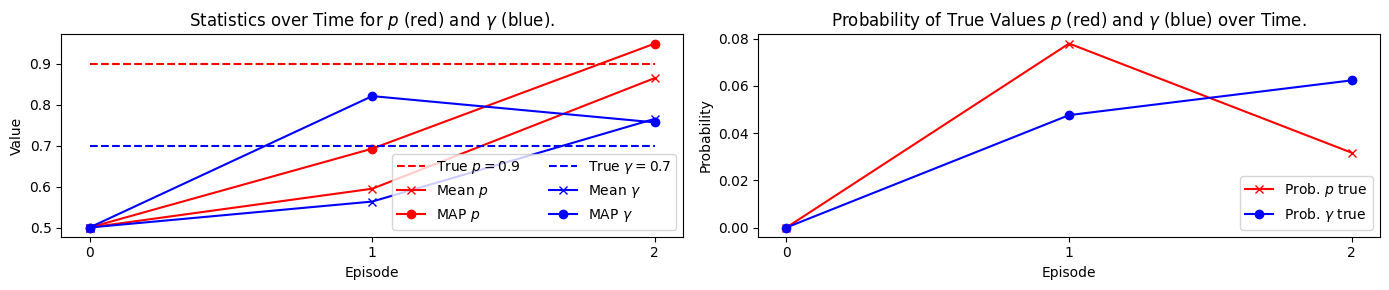

In [16]:
pos_inference.plot_statistics_over_time(episode=2, true_params=true_params)

### Episode 3

Region of interest is now $p \in [0.5,1], \gamma \in [0.5,0.8]$

Important: Now, we calculate the Behavior Map of the Maximum Regret environment from the previous environment, e.g. with the interventions.

For region of interest: ROI should have most of probability of posterior and, when we calculate the BM, have mostly one policy in it (the policy that agent currently performs) but on the borders the policy that the agent does not perform. Then, we can play around with the behavior map until the region of the current policy gets smaller.

Does the ROI have to be square?

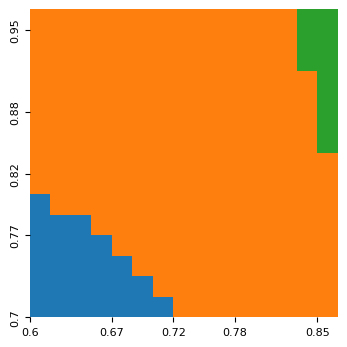

In [82]:
# Set up parameters to search over
probs = np.linspace(0.7, 0.95, granularity)
gammas = np.linspace(0.6, 0.85, granularity)

out = bm.plot_bmap(
    world=learned_world,
    gammas=gammas,
    probs=probs
)

In [99]:
height = 7
width = 7
rewards = np.zeros((height, width))
wall_states = np.zeros((height, width))

rewards[6,0] = 1
rewards[6,6] = 3

rewards[5,1] = -2.5
rewards[4,1] = -2.5
rewards[3,1] = -2.5
rewards[2,1] = -2.5
rewards[1,1] = -2.5

# rewards[5,5] = -1
# rewards[4,5] = -1

rewards = rewards.flatten()


goal_states = np.where(rewards > 0)[0]

# wall_states[2,0] = 1
# wall_states[2,1] = 1
# wall_states[4,1] = 1

# wall_states[2,0] = 1
# wall_states[2,1] = 1

wall_states = wall_states.flatten()
wall_states = np.where(wall_states > 0)[0]



agent_p = 0.9
agent_gamma = 0.7
p_true=1

true_params = ParamTuple(agent_p, agent_gamma, rewards)

T_true = transition_matrix(height, width, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


learned_world = make_world(height=height,
                          width=width,
                          rewards=rewards,
                          absorbing_states=goal_states,
                          wall_states=wall_states)

big_small_2 = Environment(
    N=height,
    M=width,
    T_true=T_true,
    wall_states=wall_states,
    R_true=rewards,
    start_state=0,
    n_walls=None,
    goal_states=goal_states
)

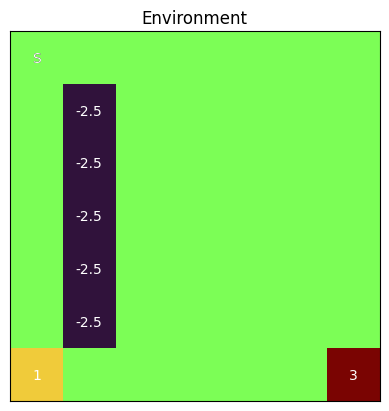

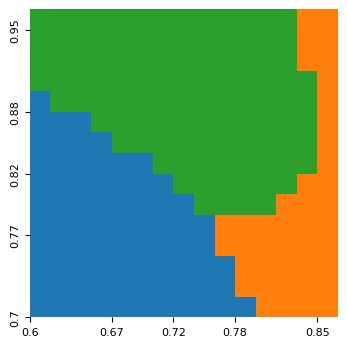

In [100]:
plot_environment(rewards.reshape(height, width), wall_states)

out = bm.plot_bmap(
    world=learned_world,
    gammas=gammas,
    probs=probs
)

In [102]:
env_update = env_design._observe_human(environment=big_small_2, n_trajectories=25)

In [104]:
env_design.all_observations.append(env_update)

In [105]:
pos_inference = PosteriorInference(expert_trajectories=env_design.all_observations)
pos_inference.calculate_posterior(num_episodes=3)

Calculate posterior for episode 0, e.g. the prior distribution.
Calculate posterior for episode 1.
Calculate posterior for episode 2.
Calculate posterior for episode 3.


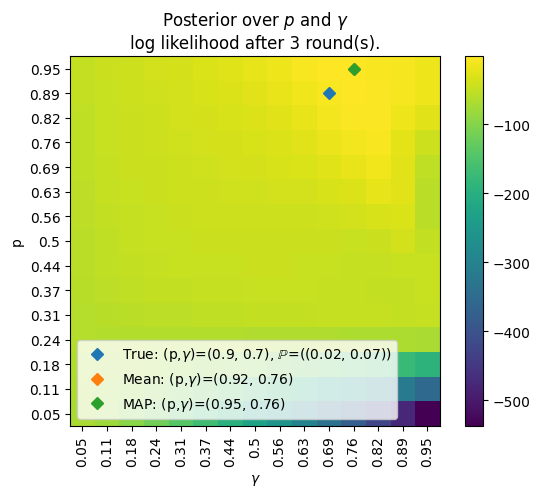

In [106]:
pos_inference.plot_posterior(episode=3, param_values=true_params, show_true_prob=True)

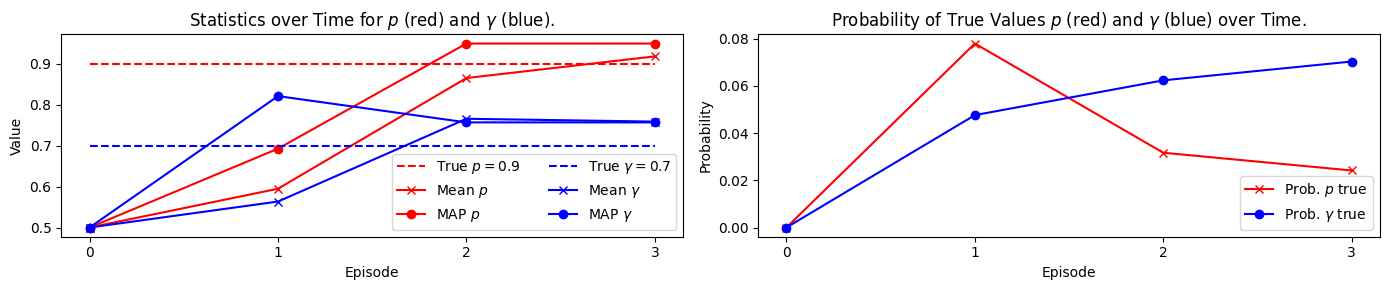

In [107]:
pos_inference.plot_statistics_over_time(episode=3, true_params=true_params)